In [3]:
%%capture
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tqdm import tqdm 
from tensorboardX import SummaryWriter

# Data Loading

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# train_transform = A.Compose([
#     A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
#     A.RandomCrop(512, 512),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ElasticTransform(p=0.2),
#     A.GridDistortion(p=0.2),
#     A.Normalize(mean=(0.5,), std=(0.5,)),  # Adjust if using RGB
#     ToTensorV2()
# ])

train_transform = A.Compose([
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=0),
    A.RandomCrop(256, 256, p= 0.5),
	A.RandomResizedCrop(scale=(0.75, 1),
						ratio=(0.95, 1.05),
						size=(256, 256)), 
	A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
	A.GaussNoise(std_range=(0.02, 0.1), p=0.6),
	
	A.RandomBrightnessContrast(brightness_limit=(-0.01, 0.01), contrast_limit=(-0.01, 0.01), p=0.5),
    A.ElasticTransform(alpha = 10, sigma = 250, p=0.5),
    A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
    # #A.CLAHE(clip_limit=.5, tile_grid_size=(8, 8), p=0.5),
	A.ShiftScaleRotate(shift_limit=(-0.005,0.005), scale_limit=(-0.2, 0.005), rotate_limit=(-30,30), border_mode=0, value=0, p=0.9), 
    A.Downscale(scale_range=(0.85,0.99), p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
	ToTensorV2()
])

val_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0),
    A.CenterCrop(512, 512),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

C:\Users\mdiqb\AppData\Local\Temp\ipykernel_14744\321926286.py:16: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0, mask_value=0),
c:\Users\mdiqb\anaconda3\envs\py312\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\mdiqb\AppData\Local\Temp\ipykernel_14744\321926286.py:31: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=(-0.005,0.005), scale_limit=(-0.2, 0.005), rotate_limit=(-30,30), border_mode=0, value=0, p=0.9),


In [27]:
from scipy.ndimage import distance_transform_edt
def compute_sdf(mask):
    pos = mask.astype(bool)
    neg = ~pos
    dist_out = distance_transform_edt(neg)
    dist_in = distance_transform_edt(pos)
    sdf = dist_out - dist_in
    return sdf

In [28]:
from PIL import Image
import os
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, test_mode=False):
        self.img_dir = img_dir
        self.mask_dir = img_dir.replace("images", "masks")
        self.transform = transform
        self.test_mode = test_mode

        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(".JPG")]
        self.imgs.sort()

        if not test_mode:
            self.masks = [f.replace('.JPG', '.PNG') for f in self.imgs]
            self.masks.sort()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = np.array(Image.open(img_path).convert('L'))  # Grayscale

        if self.test_mode:
            if self.transform:
                transformed = self.transform(image=img)
                return transformed["image"]
            return torch.tensor(img).unsqueeze(0).float() / 255.

        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = np.array(Image.open(mask_path).convert('L'))
        mask = (mask > 0).astype('float32')  # Ensure binary

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img_aug = transformed["image"]
            mask_aug = transformed["mask"]

            sdf_aug = compute_sdf(mask_aug.numpy())
            sdf_aug = np.clip(sdf_aug, -128, 128) / 128.0

            return img_aug, torch.tensor(sdf_aug).unsqueeze(0).float()

        return torch.tensor(img).unsqueeze(0).float(), torch.tensor(mask).unsqueeze(0).float()

In [29]:
root_dir = "../../data"

In [30]:
train_dataset = CustomImageDataset(
    img_dir=os.path.join(root_dir, "OTU_2d", "images"),
    transform=train_transform,
    test_mode=False
)

test_dataset = CustomImageDataset(
    img_dir=os.path.join(root_dir, "OTU_2d", "images"),
    transform=val_transform,
    test_mode=True
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


In [31]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Assuming train_dataset is your instance of CustomImageDataset
total_train_samples = len(train_dataset)
train_size = int(0.8 * total_train_samples)  # 80% for training
validation_size = total_train_samples - train_size  # 20% for validation

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Now create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Feature batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape: torch.Size([8, 1, 256, 256])


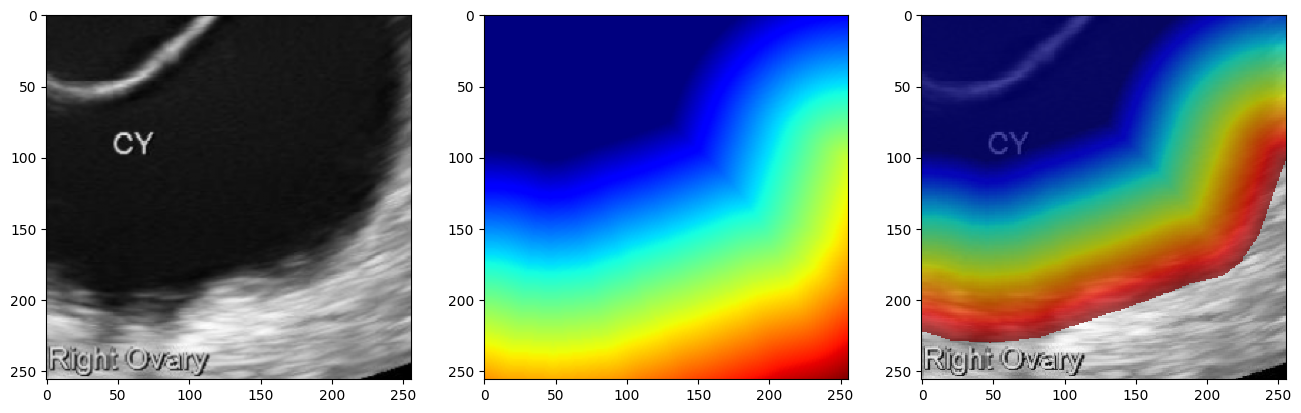

In [32]:
train_features, train_masks = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

img = train_features[0].squeeze()
mask = train_masks[0].squeeze()
img_mask = np.ma.masked_where(mask > 0, mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(mask, cmap = 'jet')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

# EDA

In [33]:
#takes long

def analyze_masks(dataloader):
    mask_presence = []

    for _, masks in dataloader:
        for mask in masks:
            # Assuming binary mask [0, 1]
            object_present = np.any(mask.numpy() > 0)
            mask_presence.append(object_present)

    return mask_presence

mask_presence_train = analyze_masks(train_dataloader)
mask_presence_validation = analyze_masks(validation_dataloader)

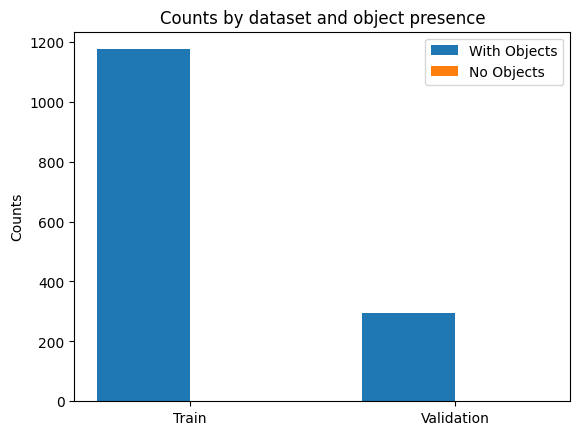

In [34]:
def plot_mask_presence(mask_presence_train, mask_presence_validation):
    train_objects = sum(mask_presence_train)
    train_no_objects = len(mask_presence_train) - train_objects
    validation_objects = sum(mask_presence_validation)
    validation_no_objects = len(mask_presence_validation) - validation_objects

    labels = ['Train', 'Validation']
    objects_counts = [train_objects, validation_objects]
    no_objects_counts = [train_no_objects, validation_no_objects]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, objects_counts, width, label='With Objects')
    rects2 = ax.bar(x + width/2, no_objects_counts, width, label='No Objects')

    ax.set_ylabel('Counts')
    ax.set_title('Counts by dataset and object presence')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_mask_presence(mask_presence_train, mask_presence_validation)

# Data Preprocessing

# Modeling

In [15]:
# %%capture
# !pip install -U segmentation-models-pytorch
# !pip install tqdm

In [35]:
import torch.nn as nn
import segmentation_models_pytorch as smp

class SDFModel(nn.Module):
    def __init__(self):
        super(SDFModel, self).__init__()
        self.backbone = smp.DeepLabV3Plus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
        # self.backbone = smp.UnetPlusPlus(
        #     encoder_name="efficientnet-b1",   # or resnet34 for speed
        #     encoder_weights="imagenet",
        #     in_channels=1,
        #     classes=1,
        # )
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.backbone(x)        # Output shape: (B, 1, H, W)
        x = self.activation(x)      # Output in [-1, 1]
        return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SDFModel()
# Move your model to the GPU
model.to(device)

Using device: cuda


SDFModel(
  (backbone): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (

In [37]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [38]:
import torch 

def SDF_Dice_Loss(inputs, targets, smooth=1):
    # No sigmoid! Inputs are raw SDF predictions.
    inputs = inputs.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (inputs * targets).sum()
    dice_score = (2. * intersection + smooth) / (inputs.pow(2).sum() + targets.pow(2).sum() + smooth)

    return 1 - dice_score


def L1_loss(inputs, targets):
    return torch.mean(torch.abs(inputs - targets))


def weighted_L1_loss(pred, target, alpha=2.0):
    weights = torch.exp(-alpha * torch.abs(target))  # Emphasize values near 0
    return (weights * torch.abs(pred - target)).mean()


def Zero_Level_Boundary_Loss(inputs, targets, threshold=0.3):
    # Zero-level masks
    pred_boundary = (torch.abs(inputs) < threshold).float()
    target_boundary = (torch.abs(targets) < threshold).float()

    intersection = (pred_boundary * target_boundary).sum()
    union = pred_boundary.sum() + target_boundary.sum()

    return 1 - (2. * intersection + 1e-5) / (union + 1e-5)

In [40]:
#loss_function = combined_loss
λ1 = 1.0
λ2 = 0.5
λ3 = 0.2

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('../../runs/trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 50
best_vloss = 1_000_000.

# Define the training function
# Define the training function
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0

    # Iterate over the training dataset
    for i, data in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_index + 1}")):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)  # Ensure labels are properly formatted

        optimizer.zero_grad()
        #outputs = model(inputs)
        pred_sdf = model(inputs)
        target_sdf = labels.float()  # Assuming labels are in the correct format for S
        #loss_value = combined_loss(outputs, labels)
        loss_value = (
                        λ1 * weighted_L1_loss(pred_sdf, target_sdf)
                        + λ2 * SDF_Dice_Loss(pred_sdf, target_sdf)
                        + λ3 * Zero_Level_Boundary_Loss(pred_sdf, target_sdf)
                    )
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # Average loss per batch
            print('  Batch {} Loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [41]:
# Main training and validation loop
EPOCHS = 50
for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.float().to(device)  # Shape: [batch_size, channels, height, width]
            vlabels = vlabels.float().to(device)

            voutputs = model(vinputs)
            #vloss = loss_function(voutputs, vlabels)  # Use the combined loss function
            vloss = (
                        λ1 * weighted_L1_loss(voutputs, vlabels.float())
                        + λ2 * SDF_Dice_Loss(voutputs, vlabels.float())
                        + λ3 * Zero_Level_Boundary_Loss(voutputs, vlabels.float())
                    )
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(validation_dataloader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../../checkpoints/deeplabv3_sdf_randomcrop/model_{}/epoch_{}'.format(timestamp, epoch_number)
        base_path = '../../checkpoints/deeplabv3_sdf_randomcrop/model_{}'.format(timestamp)
        if not os.path.exists(base_path):
            os.makedirs(base_path)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


Epoch 1:  69%|██████▊   | 101/147 [00:16<00:07,  6.11it/s]

  Batch 100 Loss: 0.3625937108695507


Epoch 1: 100%|██████████| 147/147 [00:24<00:00,  5.97it/s]


LOSS train 0.3625937108695507 valid 0.2457399332040065
EPOCH 2:


Epoch 2:  69%|██████▊   | 101/147 [00:17<00:07,  5.75it/s]

  Batch 100 Loss: 0.2492309708893299


Epoch 2: 100%|██████████| 147/147 [00:24<00:00,  5.90it/s]


LOSS train 0.2492309708893299 valid 0.1878578203755456
EPOCH 3:


Epoch 3:  69%|██████▊   | 101/147 [00:15<00:07,  6.47it/s]

  Batch 100 Loss: 0.2169349952787161


Epoch 3: 100%|██████████| 147/147 [00:22<00:00,  6.57it/s]


LOSS train 0.2169349952787161 valid 0.19782032153090914
EPOCH 4:


Epoch 4:  69%|██████▊   | 101/147 [00:16<00:07,  6.11it/s]

  Batch 100 Loss: 0.1950633402913809


Epoch 4: 100%|██████████| 147/147 [00:24<00:00,  5.98it/s]


LOSS train 0.1950633402913809 valid 0.16611350972104716
EPOCH 5:


Epoch 5:  69%|██████▊   | 101/147 [00:17<00:07,  5.86it/s]

  Batch 100 Loss: 0.18453549236059189


Epoch 5: 100%|██████████| 147/147 [00:24<00:00,  5.98it/s]


LOSS train 0.18453549236059189 valid 0.1653507850258737
EPOCH 6:


Epoch 6:  69%|██████▊   | 101/147 [00:17<00:08,  5.73it/s]

  Batch 100 Loss: 0.17205671302974224


Epoch 6: 100%|██████████| 147/147 [00:25<00:00,  5.78it/s]


LOSS train 0.17205671302974224 valid 0.1758117671753909
EPOCH 7:


Epoch 7:  69%|██████▊   | 101/147 [00:18<00:07,  6.09it/s]

  Batch 100 Loss: 0.17779303029179572


Epoch 7: 100%|██████████| 147/147 [00:26<00:00,  5.58it/s]


LOSS train 0.17779303029179572 valid 0.17821393504336075
EPOCH 8:


Epoch 8:  69%|██████▊   | 101/147 [00:17<00:07,  6.34it/s]

  Batch 100 Loss: 0.17455413371324538


Epoch 8: 100%|██████████| 147/147 [00:24<00:00,  5.95it/s]


LOSS train 0.17455413371324538 valid 0.1525902854832443
EPOCH 9:


Epoch 9:  69%|██████▊   | 101/147 [00:16<00:08,  5.68it/s]

  Batch 100 Loss: 0.16418032422661782


Epoch 9: 100%|██████████| 147/147 [00:24<00:00,  6.03it/s]


LOSS train 0.16418032422661782 valid 0.15483184581672824
EPOCH 10:


Epoch 10:  69%|██████▊   | 101/147 [00:16<00:07,  5.83it/s]

  Batch 100 Loss: 0.15826283887028694


Epoch 10: 100%|██████████| 147/147 [00:24<00:00,  6.09it/s]


LOSS train 0.15826283887028694 valid 0.12885932191400915
EPOCH 11:


Epoch 11:  69%|██████▊   | 101/147 [00:16<00:06,  6.86it/s]

  Batch 100 Loss: 0.15359801054000854


Epoch 11: 100%|██████████| 147/147 [00:23<00:00,  6.15it/s]


LOSS train 0.15359801054000854 valid 0.14654971578636686
EPOCH 12:


Epoch 12:  69%|██████▊   | 101/147 [00:16<00:07,  5.90it/s]

  Batch 100 Loss: 0.1490256453305483


Epoch 12: 100%|██████████| 147/147 [00:24<00:00,  6.04it/s]


LOSS train 0.1490256453305483 valid 0.13880516226227219
EPOCH 13:


Epoch 13:  69%|██████▊   | 101/147 [00:16<00:07,  6.33it/s]

  Batch 100 Loss: 0.14699155569076539


Epoch 13: 100%|██████████| 147/147 [00:24<00:00,  6.06it/s]


LOSS train 0.14699155569076539 valid 0.13477831323807304
EPOCH 14:


Epoch 14:  69%|██████▊   | 101/147 [00:16<00:08,  5.74it/s]

  Batch 100 Loss: 0.16115095220506193


Epoch 14: 100%|██████████| 147/147 [00:24<00:00,  5.99it/s]


LOSS train 0.16115095220506193 valid 0.1428187892243669
EPOCH 15:


Epoch 15:  69%|██████▊   | 101/147 [00:16<00:07,  5.93it/s]

  Batch 100 Loss: 0.13286192514002323


Epoch 15: 100%|██████████| 147/147 [00:24<00:00,  5.95it/s]


LOSS train 0.13286192514002323 valid 0.13948709114983276
EPOCH 16:


Epoch 16:  69%|██████▊   | 101/147 [00:15<00:07,  6.51it/s]

  Batch 100 Loss: 0.13426312480121852


Epoch 16: 100%|██████████| 147/147 [00:22<00:00,  6.67it/s]


LOSS train 0.13426312480121852 valid 0.1417583003640175
EPOCH 17:


Epoch 17:  69%|██████▊   | 101/147 [00:14<00:07,  6.53it/s]

  Batch 100 Loss: 0.14063078261911868


Epoch 17: 100%|██████████| 147/147 [00:21<00:00,  6.94it/s]


LOSS train 0.14063078261911868 valid 0.14193317596171354
EPOCH 18:


Epoch 18:  69%|██████▊   | 101/147 [00:14<00:06,  6.76it/s]

  Batch 100 Loss: 0.13616363283246755


Epoch 18: 100%|██████████| 147/147 [00:21<00:00,  6.88it/s]


LOSS train 0.13616363283246755 valid 0.12278256867382978
EPOCH 19:


Epoch 19:  69%|██████▊   | 101/147 [00:17<00:07,  6.11it/s]

  Batch 100 Loss: 0.13239630147814752


Epoch 19: 100%|██████████| 147/147 [00:24<00:00,  5.94it/s]


LOSS train 0.13239630147814752 valid 0.1546275551254685
EPOCH 20:


Epoch 20:  69%|██████▊   | 101/147 [00:15<00:06,  6.92it/s]

  Batch 100 Loss: 0.14270482368767262


Epoch 20: 100%|██████████| 147/147 [00:22<00:00,  6.63it/s]


LOSS train 0.14270482368767262 valid 0.15670359366246173
EPOCH 21:


Epoch 21:  68%|██████▊   | 100/147 [00:18<00:09,  5.05it/s]

  Batch 100 Loss: 0.12290840059518814


Epoch 21: 100%|██████████| 147/147 [00:27<00:00,  5.28it/s]


LOSS train 0.12290840059518814 valid 0.14667573601410194
EPOCH 22:


Epoch 22:  69%|██████▊   | 101/147 [00:14<00:05,  7.82it/s]

  Batch 100 Loss: 0.13369504157453777


Epoch 22: 100%|██████████| 147/147 [00:21<00:00,  6.93it/s]


LOSS train 0.13369504157453777 valid 0.13035001122468226
EPOCH 23:


Epoch 23:  69%|██████▊   | 101/147 [00:14<00:06,  7.06it/s]

  Batch 100 Loss: 0.14870317779481412


Epoch 23: 100%|██████████| 147/147 [00:21<00:00,  6.98it/s]


LOSS train 0.14870317779481412 valid 0.13090336947022257
EPOCH 24:


Epoch 24:  69%|██████▊   | 101/147 [00:14<00:06,  6.59it/s]

  Batch 100 Loss: 0.12660455111414193


Epoch 24: 100%|██████████| 147/147 [00:20<00:00,  7.00it/s]


LOSS train 0.12660455111414193 valid 0.1339831549573589
EPOCH 25:


Epoch 25:  69%|██████▊   | 101/147 [00:14<00:06,  7.23it/s]

  Batch 100 Loss: 0.126034171320498


Epoch 25: 100%|██████████| 147/147 [00:20<00:00,  7.08it/s]


LOSS train 0.126034171320498 valid 0.12918806992269852
EPOCH 26:


Epoch 26:  69%|██████▊   | 101/147 [00:13<00:06,  7.13it/s]

  Batch 100 Loss: 0.12941702723503112


Epoch 26: 100%|██████████| 147/147 [00:19<00:00,  7.40it/s]


LOSS train 0.12941702723503112 valid 0.1206901449005346
EPOCH 27:


Epoch 27:  69%|██████▊   | 101/147 [00:15<00:06,  6.72it/s]

  Batch 100 Loss: 0.13865003015846014


Epoch 27: 100%|██████████| 147/147 [00:23<00:00,  6.39it/s]


LOSS train 0.13865003015846014 valid 0.12441036286386284
EPOCH 28:


Epoch 28:  69%|██████▊   | 101/147 [00:14<00:07,  6.26it/s]

  Batch 100 Loss: 0.12385628879070282


Epoch 28: 100%|██████████| 147/147 [00:21<00:00,  6.81it/s]


LOSS train 0.12385628879070282 valid 0.11776738513160397
EPOCH 29:


Epoch 29:  69%|██████▊   | 101/147 [00:14<00:06,  6.57it/s]

  Batch 100 Loss: 0.12131597317755222


Epoch 29: 100%|██████████| 147/147 [00:21<00:00,  6.90it/s]


LOSS train 0.12131597317755222 valid 0.13365448427361412
EPOCH 30:


Epoch 30:  69%|██████▊   | 101/147 [00:14<00:06,  6.76it/s]

  Batch 100 Loss: 0.13173982698470355


Epoch 30: 100%|██████████| 147/147 [00:21<00:00,  7.00it/s]


LOSS train 0.13173982698470355 valid 0.1210003445881444
EPOCH 31:


Epoch 31:  69%|██████▊   | 101/147 [00:14<00:07,  6.39it/s]

  Batch 100 Loss: 0.12783589217811822


Epoch 31: 100%|██████████| 147/147 [00:21<00:00,  6.98it/s]


LOSS train 0.12783589217811822 valid 0.11658560021503551
EPOCH 32:


Epoch 32:  69%|██████▊   | 101/147 [00:14<00:07,  6.24it/s]

  Batch 100 Loss: 0.13970477145165205


Epoch 32: 100%|██████████| 147/147 [00:21<00:00,  6.93it/s]


LOSS train 0.13970477145165205 valid 0.12684955407638807
EPOCH 33:


Epoch 33:  69%|██████▊   | 101/147 [00:14<00:06,  7.36it/s]

  Batch 100 Loss: 0.12995277781039477


Epoch 33: 100%|██████████| 147/147 [00:20<00:00,  7.04it/s]


LOSS train 0.12995277781039477 valid 0.12783099328343933
EPOCH 34:


Epoch 34:  69%|██████▊   | 101/147 [00:14<00:06,  6.77it/s]

  Batch 100 Loss: 0.11933182928711177


Epoch 34: 100%|██████████| 147/147 [00:21<00:00,  6.95it/s]


LOSS train 0.11933182928711177 valid 0.12308197095990181
EPOCH 35:


Epoch 35:  69%|██████▊   | 101/147 [00:14<00:06,  7.13it/s]

  Batch 100 Loss: 0.11472797717899084


Epoch 35: 100%|██████████| 147/147 [00:21<00:00,  6.76it/s]


LOSS train 0.11472797717899084 valid 0.1150660892394749
EPOCH 36:


Epoch 36:  69%|██████▊   | 101/147 [00:14<00:06,  7.43it/s]

  Batch 100 Loss: 0.1235691586509347


Epoch 36: 100%|██████████| 147/147 [00:21<00:00,  6.83it/s]


LOSS train 0.1235691586509347 valid 0.1135529548533865
EPOCH 37:


Epoch 37:  69%|██████▊   | 101/147 [00:14<00:06,  7.25it/s]

  Batch 100 Loss: 0.12089901369065047


Epoch 37: 100%|██████████| 147/147 [00:21<00:00,  6.92it/s]


LOSS train 0.12089901369065047 valid 0.11994253511767129
EPOCH 38:


Epoch 38:  69%|██████▊   | 101/147 [00:14<00:06,  6.82it/s]

  Batch 100 Loss: 0.10622948970645667


Epoch 38: 100%|██████████| 147/147 [00:21<00:00,  6.94it/s]


LOSS train 0.10622948970645667 valid 0.13153591087541064
EPOCH 39:


Epoch 39:  69%|██████▊   | 101/147 [00:13<00:06,  7.59it/s]

  Batch 100 Loss: 0.11742397703230381


Epoch 39: 100%|██████████| 147/147 [00:20<00:00,  7.18it/s]


LOSS train 0.11742397703230381 valid 0.1381929174468324
EPOCH 40:


Epoch 40:  69%|██████▊   | 101/147 [00:15<00:07,  6.17it/s]

  Batch 100 Loss: 0.11606916278600693


Epoch 40: 100%|██████████| 147/147 [00:22<00:00,  6.46it/s]


LOSS train 0.11606916278600693 valid 0.12383935811954576
EPOCH 41:


Epoch 41:  69%|██████▊   | 101/147 [00:17<00:07,  5.78it/s]

  Batch 100 Loss: 0.11733570005744695


Epoch 41: 100%|██████████| 147/147 [00:25<00:00,  5.73it/s]


LOSS train 0.11733570005744695 valid 0.12540661604017825
EPOCH 42:


Epoch 42:  69%|██████▊   | 101/147 [00:17<00:07,  6.03it/s]

  Batch 100 Loss: 0.13266791466623545


Epoch 42: 100%|██████████| 147/147 [00:26<00:00,  5.63it/s]


LOSS train 0.13266791466623545 valid 0.1278149743337889
EPOCH 43:


Epoch 43:  69%|██████▊   | 101/147 [00:19<00:08,  5.36it/s]

  Batch 100 Loss: 0.11926037799566984


Epoch 43: 100%|██████████| 147/147 [00:27<00:00,  5.32it/s]


LOSS train 0.11926037799566984 valid 0.12155648824330922
EPOCH 44:


Epoch 44:  69%|██████▊   | 101/147 [00:17<00:08,  5.65it/s]

  Batch 100 Loss: 0.10708150684833527


Epoch 44: 100%|██████████| 147/147 [00:26<00:00,  5.57it/s]


LOSS train 0.10708150684833527 valid 0.11744828622888874
EPOCH 45:


Epoch 45:  68%|██████▊   | 100/147 [00:18<00:09,  4.84it/s]

  Batch 100 Loss: 0.1128920766711235


Epoch 45: 100%|██████████| 147/147 [00:27<00:00,  5.37it/s]


LOSS train 0.1128920766711235 valid 0.13051374518388026
EPOCH 46:


Epoch 46:  69%|██████▊   | 101/147 [00:16<00:07,  5.98it/s]

  Batch 100 Loss: 0.11497929241508245


Epoch 46: 100%|██████████| 147/147 [00:24<00:00,  6.12it/s]


LOSS train 0.11497929241508245 valid 0.11254910168212813
EPOCH 47:


Epoch 47:  69%|██████▊   | 101/147 [00:17<00:08,  5.67it/s]

  Batch 100 Loss: 0.10963799394667148


Epoch 47: 100%|██████████| 147/147 [00:26<00:00,  5.60it/s]


LOSS train 0.10963799394667148 valid 0.12110164086963679
EPOCH 48:


Epoch 48:  69%|██████▊   | 101/147 [00:18<00:08,  5.18it/s]

  Batch 100 Loss: 0.11242420416325331


Epoch 48: 100%|██████████| 147/147 [00:26<00:00,  5.47it/s]


LOSS train 0.11242420416325331 valid 0.12398407004169516
EPOCH 49:


Epoch 49:  69%|██████▊   | 101/147 [00:18<00:09,  4.82it/s]

  Batch 100 Loss: 0.10769796378910541


Epoch 49: 100%|██████████| 147/147 [00:27<00:00,  5.42it/s]


LOSS train 0.10769796378910541 valid 0.12237589655293
EPOCH 50:


Epoch 50:  69%|██████▊   | 101/147 [00:18<00:09,  4.81it/s]

  Batch 100 Loss: 0.10388384740799665


Epoch 50: 100%|██████████| 147/147 [00:27<00:00,  5.42it/s]


LOSS train 0.10388384740799665 valid 0.09480587725301047


# Results

## Tensorboard

In [18]:
#model_path = '../../checkpoints/deeplabv3/model_{}_{}'.format(timestamp, epoch_number)
model_path = "../../checkpoints/deeplabv3/model_20250619_211756/epoch_36"
print("Best model saved to: ", model_path)

Best model saved to:  ../../checkpoints/deeplabv3/model_20250619_211756/epoch_36


In [19]:
model.load_state_dict(torch.load(model_path))  
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for SDFModel:
	Missing key(s) in state_dict: "backbone.encoder.conv1.weight", "backbone.encoder.bn1.weight", "backbone.encoder.bn1.bias", "backbone.encoder.bn1.running_mean", "backbone.encoder.bn1.running_var", "backbone.encoder.layer1.0.conv1.weight", "backbone.encoder.layer1.0.bn1.weight", "backbone.encoder.layer1.0.bn1.bias", "backbone.encoder.layer1.0.bn1.running_mean", "backbone.encoder.layer1.0.bn1.running_var", "backbone.encoder.layer1.0.conv2.weight", "backbone.encoder.layer1.0.bn2.weight", "backbone.encoder.layer1.0.bn2.bias", "backbone.encoder.layer1.0.bn2.running_mean", "backbone.encoder.layer1.0.bn2.running_var", "backbone.encoder.layer1.1.conv1.weight", "backbone.encoder.layer1.1.bn1.weight", "backbone.encoder.layer1.1.bn1.bias", "backbone.encoder.layer1.1.bn1.running_mean", "backbone.encoder.layer1.1.bn1.running_var", "backbone.encoder.layer1.1.conv2.weight", "backbone.encoder.layer1.1.bn2.weight", "backbone.encoder.layer1.1.bn2.bias", "backbone.encoder.layer1.1.bn2.running_mean", "backbone.encoder.layer1.1.bn2.running_var", "backbone.encoder.layer1.2.conv1.weight", "backbone.encoder.layer1.2.bn1.weight", "backbone.encoder.layer1.2.bn1.bias", "backbone.encoder.layer1.2.bn1.running_mean", "backbone.encoder.layer1.2.bn1.running_var", "backbone.encoder.layer1.2.conv2.weight", "backbone.encoder.layer1.2.bn2.weight", "backbone.encoder.layer1.2.bn2.bias", "backbone.encoder.layer1.2.bn2.running_mean", "backbone.encoder.layer1.2.bn2.running_var", "backbone.encoder.layer2.0.conv1.weight", "backbone.encoder.layer2.0.bn1.weight", "backbone.encoder.layer2.0.bn1.bias", "backbone.encoder.layer2.0.bn1.running_mean", "backbone.encoder.layer2.0.bn1.running_var", "backbone.encoder.layer2.0.conv2.weight", "backbone.encoder.layer2.0.bn2.weight", "backbone.encoder.layer2.0.bn2.bias", "backbone.encoder.layer2.0.bn2.running_mean", "backbone.encoder.layer2.0.bn2.running_var", "backbone.encoder.layer2.0.downsample.0.weight", "backbone.encoder.layer2.0.downsample.1.weight", "backbone.encoder.layer2.0.downsample.1.bias", "backbone.encoder.layer2.0.downsample.1.running_mean", "backbone.encoder.layer2.0.downsample.1.running_var", "backbone.encoder.layer2.1.conv1.weight", "backbone.encoder.layer2.1.bn1.weight", "backbone.encoder.layer2.1.bn1.bias", "backbone.encoder.layer2.1.bn1.running_mean", "backbone.encoder.layer2.1.bn1.running_var", "backbone.encoder.layer2.1.conv2.weight", "backbone.encoder.layer2.1.bn2.weight", "backbone.encoder.layer2.1.bn2.bias", "backbone.encoder.layer2.1.bn2.running_mean", "backbone.encoder.layer2.1.bn2.running_var", "backbone.encoder.layer2.2.conv1.weight", "backbone.encoder.layer2.2.bn1.weight", "backbone.encoder.layer2.2.bn1.bias", "backbone.encoder.layer2.2.bn1.running_mean", "backbone.encoder.layer2.2.bn1.running_var", "backbone.encoder.layer2.2.conv2.weight", "backbone.encoder.layer2.2.bn2.weight", "backbone.encoder.layer2.2.bn2.bias", "backbone.encoder.layer2.2.bn2.running_mean", "backbone.encoder.layer2.2.bn2.running_var", "backbone.encoder.layer2.3.conv1.weight", "backbone.encoder.layer2.3.bn1.weight", "backbone.encoder.layer2.3.bn1.bias", "backbone.encoder.layer2.3.bn1.running_mean", "backbone.encoder.layer2.3.bn1.running_var", "backbone.encoder.layer2.3.conv2.weight", "backbone.encoder.layer2.3.bn2.weight", "backbone.encoder.layer2.3.bn2.bias", "backbone.encoder.layer2.3.bn2.running_mean", "backbone.encoder.layer2.3.bn2.running_var", "backbone.encoder.layer3.0.conv1.weight", "backbone.encoder.layer3.0.bn1.weight", "backbone.encoder.layer3.0.bn1.bias", "backbone.encoder.layer3.0.bn1.running_mean", "backbone.encoder.layer3.0.bn1.running_var", "backbone.encoder.layer3.0.conv2.weight", "backbone.encoder.layer3.0.bn2.weight", "backbone.encoder.layer3.0.bn2.bias", "backbone.encoder.layer3.0.bn2.running_mean", "backbone.encoder.layer3.0.bn2.running_var", "backbone.encoder.layer3.0.downsample.0.weight", "backbone.encoder.layer3.0.downsample.1.weight", "backbone.encoder.layer3.0.downsample.1.bias", "backbone.encoder.layer3.0.downsample.1.running_mean", "backbone.encoder.layer3.0.downsample.1.running_var", "backbone.encoder.layer3.1.conv1.weight", "backbone.encoder.layer3.1.bn1.weight", "backbone.encoder.layer3.1.bn1.bias", "backbone.encoder.layer3.1.bn1.running_mean", "backbone.encoder.layer3.1.bn1.running_var", "backbone.encoder.layer3.1.conv2.weight", "backbone.encoder.layer3.1.bn2.weight", "backbone.encoder.layer3.1.bn2.bias", "backbone.encoder.layer3.1.bn2.running_mean", "backbone.encoder.layer3.1.bn2.running_var", "backbone.encoder.layer3.2.conv1.weight", "backbone.encoder.layer3.2.bn1.weight", "backbone.encoder.layer3.2.bn1.bias", "backbone.encoder.layer3.2.bn1.running_mean", "backbone.encoder.layer3.2.bn1.running_var", "backbone.encoder.layer3.2.conv2.weight", "backbone.encoder.layer3.2.bn2.weight", "backbone.encoder.layer3.2.bn2.bias", "backbone.encoder.layer3.2.bn2.running_mean", "backbone.encoder.layer3.2.bn2.running_var", "backbone.encoder.layer3.3.conv1.weight", "backbone.encoder.layer3.3.bn1.weight", "backbone.encoder.layer3.3.bn1.bias", "backbone.encoder.layer3.3.bn1.running_mean", "backbone.encoder.layer3.3.bn1.running_var", "backbone.encoder.layer3.3.conv2.weight", "backbone.encoder.layer3.3.bn2.weight", "backbone.encoder.layer3.3.bn2.bias", "backbone.encoder.layer3.3.bn2.running_mean", "backbone.encoder.layer3.3.bn2.running_var", "backbone.encoder.layer3.4.conv1.weight", "backbone.encoder.layer3.4.bn1.weight", "backbone.encoder.layer3.4.bn1.bias", "backbone.encoder.layer3.4.bn1.running_mean", "backbone.encoder.layer3.4.bn1.running_var", "backbone.encoder.layer3.4.conv2.weight", "backbone.encoder.layer3.4.bn2.weight", "backbone.encoder.layer3.4.bn2.bias", "backbone.encoder.layer3.4.bn2.running_mean", "backbone.encoder.layer3.4.bn2.running_var", "backbone.encoder.layer3.5.conv1.weight", "backbone.encoder.layer3.5.bn1.weight", "backbone.encoder.layer3.5.bn1.bias", "backbone.encoder.layer3.5.bn1.running_mean", "backbone.encoder.layer3.5.bn1.running_var", "backbone.encoder.layer3.5.conv2.weight", "backbone.encoder.layer3.5.bn2.weight", "backbone.encoder.layer3.5.bn2.bias", "backbone.encoder.layer3.5.bn2.running_mean", "backbone.encoder.layer3.5.bn2.running_var", "backbone.encoder.layer4.0.conv1.weight", "backbone.encoder.layer4.0.bn1.weight", "backbone.encoder.layer4.0.bn1.bias", "backbone.encoder.layer4.0.bn1.running_mean", "backbone.encoder.layer4.0.bn1.running_var", "backbone.encoder.layer4.0.conv2.weight", "backbone.encoder.layer4.0.bn2.weight", "backbone.encoder.layer4.0.bn2.bias", "backbone.encoder.layer4.0.bn2.running_mean", "backbone.encoder.layer4.0.bn2.running_var", "backbone.encoder.layer4.0.downsample.0.weight", "backbone.encoder.layer4.0.downsample.1.weight", "backbone.encoder.layer4.0.downsample.1.bias", "backbone.encoder.layer4.0.downsample.1.running_mean", "backbone.encoder.layer4.0.downsample.1.running_var", "backbone.encoder.layer4.1.conv1.weight", "backbone.encoder.layer4.1.bn1.weight", "backbone.encoder.layer4.1.bn1.bias", "backbone.encoder.layer4.1.bn1.running_mean", "backbone.encoder.layer4.1.bn1.running_var", "backbone.encoder.layer4.1.conv2.weight", "backbone.encoder.layer4.1.bn2.weight", "backbone.encoder.layer4.1.bn2.bias", "backbone.encoder.layer4.1.bn2.running_mean", "backbone.encoder.layer4.1.bn2.running_var", "backbone.encoder.layer4.2.conv1.weight", "backbone.encoder.layer4.2.bn1.weight", "backbone.encoder.layer4.2.bn1.bias", "backbone.encoder.layer4.2.bn1.running_mean", "backbone.encoder.layer4.2.bn1.running_var", "backbone.encoder.layer4.2.conv2.weight", "backbone.encoder.layer4.2.bn2.weight", "backbone.encoder.layer4.2.bn2.bias", "backbone.encoder.layer4.2.bn2.running_mean", "backbone.encoder.layer4.2.bn2.running_var", "backbone.decoder.aspp.0.convs.0.0.weight", "backbone.decoder.aspp.0.convs.0.1.weight", "backbone.decoder.aspp.0.convs.0.1.bias", "backbone.decoder.aspp.0.convs.0.1.running_mean", "backbone.decoder.aspp.0.convs.0.1.running_var", "backbone.decoder.aspp.0.convs.1.0.0.weight", "backbone.decoder.aspp.0.convs.1.0.1.weight", "backbone.decoder.aspp.0.convs.1.1.weight", "backbone.decoder.aspp.0.convs.1.1.bias", "backbone.decoder.aspp.0.convs.1.1.running_mean", "backbone.decoder.aspp.0.convs.1.1.running_var", "backbone.decoder.aspp.0.convs.2.0.0.weight", "backbone.decoder.aspp.0.convs.2.0.1.weight", "backbone.decoder.aspp.0.convs.2.1.weight", "backbone.decoder.aspp.0.convs.2.1.bias", "backbone.decoder.aspp.0.convs.2.1.running_mean", "backbone.decoder.aspp.0.convs.2.1.running_var", "backbone.decoder.aspp.0.convs.3.0.0.weight", "backbone.decoder.aspp.0.convs.3.0.1.weight", "backbone.decoder.aspp.0.convs.3.1.weight", "backbone.decoder.aspp.0.convs.3.1.bias", "backbone.decoder.aspp.0.convs.3.1.running_mean", "backbone.decoder.aspp.0.convs.3.1.running_var", "backbone.decoder.aspp.0.convs.4.1.weight", "backbone.decoder.aspp.0.convs.4.2.weight", "backbone.decoder.aspp.0.convs.4.2.bias", "backbone.decoder.aspp.0.convs.4.2.running_mean", "backbone.decoder.aspp.0.convs.4.2.running_var", "backbone.decoder.aspp.0.project.0.weight", "backbone.decoder.aspp.0.project.1.weight", "backbone.decoder.aspp.0.project.1.bias", "backbone.decoder.aspp.0.project.1.running_mean", "backbone.decoder.aspp.0.project.1.running_var", "backbone.decoder.aspp.1.0.weight", "backbone.decoder.aspp.1.1.weight", "backbone.decoder.aspp.2.weight", "backbone.decoder.aspp.2.bias", "backbone.decoder.aspp.2.running_mean", "backbone.decoder.aspp.2.running_var", "backbone.decoder.block1.0.weight", "backbone.decoder.block1.1.weight", "backbone.decoder.block1.1.bias", "backbone.decoder.block1.1.running_mean", "backbone.decoder.block1.1.running_var", "backbone.decoder.block2.0.0.weight", "backbone.decoder.block2.0.1.weight", "backbone.decoder.block2.1.weight", "backbone.decoder.block2.1.bias", "backbone.decoder.block2.1.running_mean", "backbone.decoder.block2.1.running_var". 
	Unexpected key(s) in state_dict: "backbone.encoder._conv_stem.weight", "backbone.encoder._bn0.weight", "backbone.encoder._bn0.bias", "backbone.encoder._bn0.running_mean", "backbone.encoder._bn0.running_var", "backbone.encoder._bn0.num_batches_tracked", "backbone.encoder._blocks.0._depthwise_conv.weight", "backbone.encoder._blocks.0._bn1.weight", "backbone.encoder._blocks.0._bn1.bias", "backbone.encoder._blocks.0._bn1.running_mean", "backbone.encoder._blocks.0._bn1.running_var", "backbone.encoder._blocks.0._bn1.num_batches_tracked", "backbone.encoder._blocks.0._se_reduce.weight", "backbone.encoder._blocks.0._se_reduce.bias", "backbone.encoder._blocks.0._se_expand.weight", "backbone.encoder._blocks.0._se_expand.bias", "backbone.encoder._blocks.0._project_conv.weight", "backbone.encoder._blocks.0._bn2.weight", "backbone.encoder._blocks.0._bn2.bias", "backbone.encoder._blocks.0._bn2.running_mean", "backbone.encoder._blocks.0._bn2.running_var", "backbone.encoder._blocks.0._bn2.num_batches_tracked", "backbone.encoder._blocks.1._depthwise_conv.weight", "backbone.encoder._blocks.1._bn1.weight", "backbone.encoder._blocks.1._bn1.bias", "backbone.encoder._blocks.1._bn1.running_mean", "backbone.encoder._blocks.1._bn1.running_var", "backbone.encoder._blocks.1._bn1.num_batches_tracked", "backbone.encoder._blocks.1._se_reduce.weight", "backbone.encoder._blocks.1._se_reduce.bias", "backbone.encoder._blocks.1._se_expand.weight", "backbone.encoder._blocks.1._se_expand.bias", "backbone.encoder._blocks.1._project_conv.weight", "backbone.encoder._blocks.1._bn2.weight", "backbone.encoder._blocks.1._bn2.bias", "backbone.encoder._blocks.1._bn2.running_mean", "backbone.encoder._blocks.1._bn2.running_var", "backbone.encoder._blocks.1._bn2.num_batches_tracked", "backbone.encoder._blocks.2._expand_conv.weight", "backbone.encoder._blocks.2._bn0.weight", "backbone.encoder._blocks.2._bn0.bias", "backbone.encoder._blocks.2._bn0.running_mean", "backbone.encoder._blocks.2._bn0.running_var", "backbone.encoder._blocks.2._bn0.num_batches_tracked", "backbone.encoder._blocks.2._depthwise_conv.weight", "backbone.encoder._blocks.2._bn1.weight", "backbone.encoder._blocks.2._bn1.bias", "backbone.encoder._blocks.2._bn1.running_mean", "backbone.encoder._blocks.2._bn1.running_var", "backbone.encoder._blocks.2._bn1.num_batches_tracked", "backbone.encoder._blocks.2._se_reduce.weight", "backbone.encoder._blocks.2._se_reduce.bias", "backbone.encoder._blocks.2._se_expand.weight", "backbone.encoder._blocks.2._se_expand.bias", "backbone.encoder._blocks.2._project_conv.weight", "backbone.encoder._blocks.2._bn2.weight", "backbone.encoder._blocks.2._bn2.bias", "backbone.encoder._blocks.2._bn2.running_mean", "backbone.encoder._blocks.2._bn2.running_var", "backbone.encoder._blocks.2._bn2.num_batches_tracked", "backbone.encoder._blocks.3._expand_conv.weight", "backbone.encoder._blocks.3._bn0.weight", "backbone.encoder._blocks.3._bn0.bias", "backbone.encoder._blocks.3._bn0.running_mean", "backbone.encoder._blocks.3._bn0.running_var", "backbone.encoder._blocks.3._bn0.num_batches_tracked", "backbone.encoder._blocks.3._depthwise_conv.weight", "backbone.encoder._blocks.3._bn1.weight", "backbone.encoder._blocks.3._bn1.bias", "backbone.encoder._blocks.3._bn1.running_mean", "backbone.encoder._blocks.3._bn1.running_var", "backbone.encoder._blocks.3._bn1.num_batches_tracked", "backbone.encoder._blocks.3._se_reduce.weight", "backbone.encoder._blocks.3._se_reduce.bias", "backbone.encoder._blocks.3._se_expand.weight", "backbone.encoder._blocks.3._se_expand.bias", "backbone.encoder._blocks.3._project_conv.weight", "backbone.encoder._blocks.3._bn2.weight", "backbone.encoder._blocks.3._bn2.bias", "backbone.encoder._blocks.3._bn2.running_mean", "backbone.encoder._blocks.3._bn2.running_var", "backbone.encoder._blocks.3._bn2.num_batches_tracked", "backbone.encoder._blocks.4._expand_conv.weight", "backbone.encoder._blocks.4._bn0.weight", "backbone.encoder._blocks.4._bn0.bias", "backbone.encoder._blocks.4._bn0.running_mean", "backbone.encoder._blocks.4._bn0.running_var", "backbone.encoder._blocks.4._bn0.num_batches_tracked", "backbone.encoder._blocks.4._depthwise_conv.weight", "backbone.encoder._blocks.4._bn1.weight", "backbone.encoder._blocks.4._bn1.bias", "backbone.encoder._blocks.4._bn1.running_mean", "backbone.encoder._blocks.4._bn1.running_var", "backbone.encoder._blocks.4._bn1.num_batches_tracked", "backbone.encoder._blocks.4._se_reduce.weight", "backbone.encoder._blocks.4._se_reduce.bias", "backbone.encoder._blocks.4._se_expand.weight", "backbone.encoder._blocks.4._se_expand.bias", "backbone.encoder._blocks.4._project_conv.weight", "backbone.encoder._blocks.4._bn2.weight", "backbone.encoder._blocks.4._bn2.bias", "backbone.encoder._blocks.4._bn2.running_mean", "backbone.encoder._blocks.4._bn2.running_var", "backbone.encoder._blocks.4._bn2.num_batches_tracked", "backbone.encoder._blocks.5._expand_conv.weight", "backbone.encoder._blocks.5._bn0.weight", "backbone.encoder._blocks.5._bn0.bias", "backbone.encoder._blocks.5._bn0.running_mean", "backbone.encoder._blocks.5._bn0.running_var", "backbone.encoder._blocks.5._bn0.num_batches_tracked", "backbone.encoder._blocks.5._depthwise_conv.weight", "backbone.encoder._blocks.5._bn1.weight", "backbone.encoder._blocks.5._bn1.bias", "backbone.encoder._blocks.5._bn1.running_mean", "backbone.encoder._blocks.5._bn1.running_var", "backbone.encoder._blocks.5._bn1.num_batches_tracked", "backbone.encoder._blocks.5._se_reduce.weight", "backbone.encoder._blocks.5._se_reduce.bias", "backbone.encoder._blocks.5._se_expand.weight", "backbone.encoder._blocks.5._se_expand.bias", "backbone.encoder._blocks.5._project_conv.weight", "backbone.encoder._blocks.5._bn2.weight", "backbone.encoder._blocks.5._bn2.bias", "backbone.encoder._blocks.5._bn2.running_mean", "backbone.encoder._blocks.5._bn2.running_var", "backbone.encoder._blocks.5._bn2.num_batches_tracked", "backbone.encoder._blocks.6._expand_conv.weight", "backbone.encoder._blocks.6._bn0.weight", "backbone.encoder._blocks.6._bn0.bias", "backbone.encoder._blocks.6._bn0.running_mean", "backbone.encoder._blocks.6._bn0.running_var", "backbone.encoder._blocks.6._bn0.num_batches_tracked", "backbone.encoder._blocks.6._depthwise_conv.weight", "backbone.encoder._blocks.6._bn1.weight", "backbone.encoder._blocks.6._bn1.bias", "backbone.encoder._blocks.6._bn1.running_mean", "backbone.encoder._blocks.6._bn1.running_var", "backbone.encoder._blocks.6._bn1.num_batches_tracked", "backbone.encoder._blocks.6._se_reduce.weight", "backbone.encoder._blocks.6._se_reduce.bias", "backbone.encoder._blocks.6._se_expand.weight", "backbone.encoder._blocks.6._se_expand.bias", "backbone.encoder._blocks.6._project_conv.weight", "backbone.encoder._blocks.6._bn2.weight", "backbone.encoder._blocks.6._bn2.bias", "backbone.encoder._blocks.6._bn2.running_mean", "backbone.encoder._blocks.6._bn2.running_var", "backbone.encoder._blocks.6._bn2.num_batches_tracked", "backbone.encoder._blocks.7._expand_conv.weight", "backbone.encoder._blocks.7._bn0.weight", "backbone.encoder._blocks.7._bn0.bias", "backbone.encoder._blocks.7._bn0.running_mean", "backbone.encoder._blocks.7._bn0.running_var", "backbone.encoder._blocks.7._bn0.num_batches_tracked", "backbone.encoder._blocks.7._depthwise_conv.weight", "backbone.encoder._blocks.7._bn1.weight", "backbone.encoder._blocks.7._bn1.bias", "backbone.encoder._blocks.7._bn1.running_mean", "backbone.encoder._blocks.7._bn1.running_var", "backbone.encoder._blocks.7._bn1.num_batches_tracked", "backbone.encoder._blocks.7._se_reduce.weight", "backbone.encoder._blocks.7._se_reduce.bias", "backbone.encoder._blocks.7._se_expand.weight", "backbone.encoder._blocks.7._se_expand.bias", "backbone.encoder._blocks.7._project_conv.weight", "backbone.encoder._blocks.7._bn2.weight", "backbone.encoder._blocks.7._bn2.bias", "backbone.encoder._blocks.7._bn2.running_mean", "backbone.encoder._blocks.7._bn2.running_var", "backbone.encoder._blocks.7._bn2.num_batches_tracked", "backbone.encoder._blocks.8._expand_conv.weight", "backbone.encoder._blocks.8._bn0.weight", "backbone.encoder._blocks.8._bn0.bias", "backbone.encoder._blocks.8._bn0.running_mean", "backbone.encoder._blocks.8._bn0.running_var", "backbone.encoder._blocks.8._bn0.num_batches_tracked", "backbone.encoder._blocks.8._depthwise_conv.weight", "backbone.encoder._blocks.8._bn1.weight", "backbone.encoder._blocks.8._bn1.bias", "backbone.encoder._blocks.8._bn1.running_mean", "backbone.encoder._blocks.8._bn1.running_var", "backbone.encoder._blocks.8._bn1.num_batches_tracked", "backbone.encoder._blocks.8._se_reduce.weight", "backbone.encoder._blocks.8._se_reduce.bias", "backbone.encoder._blocks.8._se_expand.weight", "backbone.encoder._blocks.8._se_expand.bias", "backbone.encoder._blocks.8._project_conv.weight", "backbone.encoder._blocks.8._bn2.weight", "backbone.encoder._blocks.8._bn2.bias", "backbone.encoder._blocks.8._bn2.running_mean", "backbone.encoder._blocks.8._bn2.running_var", "backbone.encoder._blocks.8._bn2.num_batches_tracked", "backbone.encoder._blocks.9._expand_conv.weight", "backbone.encoder._blocks.9._bn0.weight", "backbone.encoder._blocks.9._bn0.bias", "backbone.encoder._blocks.9._bn0.running_mean", "backbone.encoder._blocks.9._bn0.running_var", "backbone.encoder._blocks.9._bn0.num_batches_tracked", "backbone.encoder._blocks.9._depthwise_conv.weight", "backbone.encoder._blocks.9._bn1.weight", "backbone.encoder._blocks.9._bn1.bias", "backbone.encoder._blocks.9._bn1.running_mean", "backbone.encoder._blocks.9._bn1.running_var", "backbone.encoder._blocks.9._bn1.num_batches_tracked", "backbone.encoder._blocks.9._se_reduce.weight", "backbone.encoder._blocks.9._se_reduce.bias", "backbone.encoder._blocks.9._se_expand.weight", "backbone.encoder._blocks.9._se_expand.bias", "backbone.encoder._blocks.9._project_conv.weight", "backbone.encoder._blocks.9._bn2.weight", "backbone.encoder._blocks.9._bn2.bias", "backbone.encoder._blocks.9._bn2.running_mean", "backbone.encoder._blocks.9._bn2.running_var", "backbone.encoder._blocks.9._bn2.num_batches_tracked", "backbone.encoder._blocks.10._expand_conv.weight", "backbone.encoder._blocks.10._bn0.weight", "backbone.encoder._blocks.10._bn0.bias", "backbone.encoder._blocks.10._bn0.running_mean", "backbone.encoder._blocks.10._bn0.running_var", "backbone.encoder._blocks.10._bn0.num_batches_tracked", "backbone.encoder._blocks.10._depthwise_conv.weight", "backbone.encoder._blocks.10._bn1.weight", "backbone.encoder._blocks.10._bn1.bias", "backbone.encoder._blocks.10._bn1.running_mean", "backbone.encoder._blocks.10._bn1.running_var", "backbone.encoder._blocks.10._bn1.num_batches_tracked", "backbone.encoder._blocks.10._se_reduce.weight", "backbone.encoder._blocks.10._se_reduce.bias", "backbone.encoder._blocks.10._se_expand.weight", "backbone.encoder._blocks.10._se_expand.bias", "backbone.encoder._blocks.10._project_conv.weight", "backbone.encoder._blocks.10._bn2.weight", "backbone.encoder._blocks.10._bn2.bias", "backbone.encoder._blocks.10._bn2.running_mean", "backbone.encoder._blocks.10._bn2.running_var", "backbone.encoder._blocks.10._bn2.num_batches_tracked", "backbone.encoder._blocks.11._expand_conv.weight", "backbone.encoder._blocks.11._bn0.weight", "backbone.encoder._blocks.11._bn0.bias", "backbone.encoder._blocks.11._bn0.running_mean", "backbone.encoder._blocks.11._bn0.running_var", "backbone.encoder._blocks.11._bn0.num_batches_tracked", "backbone.encoder._blocks.11._depthwise_conv.weight", "backbone.encoder._blocks.11._bn1.weight", "backbone.encoder._blocks.11._bn1.bias", "backbone.encoder._blocks.11._bn1.running_mean", "backbone.encoder._blocks.11._bn1.running_var", "backbone.encoder._blocks.11._bn1.num_batches_tracked", "backbone.encoder._blocks.11._se_reduce.weight", "backbone.encoder._blocks.11._se_reduce.bias", "backbone.encoder._blocks.11._se_expand.weight", "backbone.encoder._blocks.11._se_expand.bias", "backbone.encoder._blocks.11._project_conv.weight", "backbone.encoder._blocks.11._bn2.weight", "backbone.encoder._blocks.11._bn2.bias", "backbone.encoder._blocks.11._bn2.running_mean", "backbone.encoder._blocks.11._bn2.running_var", "backbone.encoder._blocks.11._bn2.num_batches_tracked", "backbone.encoder._blocks.12._expand_conv.weight", "backbone.encoder._blocks.12._bn0.weight", "backbone.encoder._blocks.12._bn0.bias", "backbone.encoder._blocks.12._bn0.running_mean", "backbone.encoder._blocks.12._bn0.running_var", "backbone.encoder._blocks.12._bn0.num_batches_tracked", "backbone.encoder._blocks.12._depthwise_conv.weight", "backbone.encoder._blocks.12._bn1.weight", "backbone.encoder._blocks.12._bn1.bias", "backbone.encoder._blocks.12._bn1.running_mean", "backbone.encoder._blocks.12._bn1.running_var", "backbone.encoder._blocks.12._bn1.num_batches_tracked", "backbone.encoder._blocks.12._se_reduce.weight", "backbone.encoder._blocks.12._se_reduce.bias", "backbone.encoder._blocks.12._se_expand.weight", "backbone.encoder._blocks.12._se_expand.bias", "backbone.encoder._blocks.12._project_conv.weight", "backbone.encoder._blocks.12._bn2.weight", "backbone.encoder._blocks.12._bn2.bias", "backbone.encoder._blocks.12._bn2.running_mean", "backbone.encoder._blocks.12._bn2.running_var", "backbone.encoder._blocks.12._bn2.num_batches_tracked", "backbone.encoder._blocks.13._expand_conv.weight", "backbone.encoder._blocks.13._bn0.weight", "backbone.encoder._blocks.13._bn0.bias", "backbone.encoder._blocks.13._bn0.running_mean", "backbone.encoder._blocks.13._bn0.running_var", "backbone.encoder._blocks.13._bn0.num_batches_tracked", "backbone.encoder._blocks.13._depthwise_conv.weight", "backbone.encoder._blocks.13._bn1.weight", "backbone.encoder._blocks.13._bn1.bias", "backbone.encoder._blocks.13._bn1.running_mean", "backbone.encoder._blocks.13._bn1.running_var", "backbone.encoder._blocks.13._bn1.num_batches_tracked", "backbone.encoder._blocks.13._se_reduce.weight", "backbone.encoder._blocks.13._se_reduce.bias", "backbone.encoder._blocks.13._se_expand.weight", "backbone.encoder._blocks.13._se_expand.bias", "backbone.encoder._blocks.13._project_conv.weight", "backbone.encoder._blocks.13._bn2.weight", "backbone.encoder._blocks.13._bn2.bias", "backbone.encoder._blocks.13._bn2.running_mean", "backbone.encoder._blocks.13._bn2.running_var", "backbone.encoder._blocks.13._bn2.num_batches_tracked", "backbone.encoder._blocks.14._expand_conv.weight", "backbone.encoder._blocks.14._bn0.weight", "backbone.encoder._blocks.14._bn0.bias", "backbone.encoder._blocks.14._bn0.running_mean", "backbone.encoder._blocks.14._bn0.running_var", "backbone.encoder._blocks.14._bn0.num_batches_tracked", "backbone.encoder._blocks.14._depthwise_conv.weight", "backbone.encoder._blocks.14._bn1.weight", "backbone.encoder._blocks.14._bn1.bias", "backbone.encoder._blocks.14._bn1.running_mean", "backbone.encoder._blocks.14._bn1.running_var", "backbone.encoder._blocks.14._bn1.num_batches_tracked", "backbone.encoder._blocks.14._se_reduce.weight", "backbone.encoder._blocks.14._se_reduce.bias", "backbone.encoder._blocks.14._se_expand.weight", "backbone.encoder._blocks.14._se_expand.bias", "backbone.encoder._blocks.14._project_conv.weight", "backbone.encoder._blocks.14._bn2.weight", "backbone.encoder._blocks.14._bn2.bias", "backbone.encoder._blocks.14._bn2.running_mean", "backbone.encoder._blocks.14._bn2.running_var", "backbone.encoder._blocks.14._bn2.num_batches_tracked", "backbone.encoder._blocks.15._expand_conv.weight", "backbone.encoder._blocks.15._bn0.weight", "backbone.encoder._blocks.15._bn0.bias", "backbone.encoder._blocks.15._bn0.running_mean", "backbone.encoder._blocks.15._bn0.running_var", "backbone.encoder._blocks.15._bn0.num_batches_tracked", "backbone.encoder._blocks.15._depthwise_conv.weight", "backbone.encoder._blocks.15._bn1.weight", "backbone.encoder._blocks.15._bn1.bias", "backbone.encoder._blocks.15._bn1.running_mean", "backbone.encoder._blocks.15._bn1.running_var", "backbone.encoder._blocks.15._bn1.num_batches_tracked", "backbone.encoder._blocks.15._se_reduce.weight", "backbone.encoder._blocks.15._se_reduce.bias", "backbone.encoder._blocks.15._se_expand.weight", "backbone.encoder._blocks.15._se_expand.bias", "backbone.encoder._blocks.15._project_conv.weight", "backbone.encoder._blocks.15._bn2.weight", "backbone.encoder._blocks.15._bn2.bias", "backbone.encoder._blocks.15._bn2.running_mean", "backbone.encoder._blocks.15._bn2.running_var", "backbone.encoder._blocks.15._bn2.num_batches_tracked", "backbone.encoder._blocks.16._expand_conv.weight", "backbone.encoder._blocks.16._bn0.weight", "backbone.encoder._blocks.16._bn0.bias", "backbone.encoder._blocks.16._bn0.running_mean", "backbone.encoder._blocks.16._bn0.running_var", "backbone.encoder._blocks.16._bn0.num_batches_tracked", "backbone.encoder._blocks.16._depthwise_conv.weight", "backbone.encoder._blocks.16._bn1.weight", "backbone.encoder._blocks.16._bn1.bias", "backbone.encoder._blocks.16._bn1.running_mean", "backbone.encoder._blocks.16._bn1.running_var", "backbone.encoder._blocks.16._bn1.num_batches_tracked", "backbone.encoder._blocks.16._se_reduce.weight", "backbone.encoder._blocks.16._se_reduce.bias", "backbone.encoder._blocks.16._se_expand.weight", "backbone.encoder._blocks.16._se_expand.bias", "backbone.encoder._blocks.16._project_conv.weight", "backbone.encoder._blocks.16._bn2.weight", "backbone.encoder._blocks.16._bn2.bias", "backbone.encoder._blocks.16._bn2.running_mean", "backbone.encoder._blocks.16._bn2.running_var", "backbone.encoder._blocks.16._bn2.num_batches_tracked", "backbone.encoder._blocks.17._expand_conv.weight", "backbone.encoder._blocks.17._bn0.weight", "backbone.encoder._blocks.17._bn0.bias", "backbone.encoder._blocks.17._bn0.running_mean", "backbone.encoder._blocks.17._bn0.running_var", "backbone.encoder._blocks.17._bn0.num_batches_tracked", "backbone.encoder._blocks.17._depthwise_conv.weight", "backbone.encoder._blocks.17._bn1.weight", "backbone.encoder._blocks.17._bn1.bias", "backbone.encoder._blocks.17._bn1.running_mean", "backbone.encoder._blocks.17._bn1.running_var", "backbone.encoder._blocks.17._bn1.num_batches_tracked", "backbone.encoder._blocks.17._se_reduce.weight", "backbone.encoder._blocks.17._se_reduce.bias", "backbone.encoder._blocks.17._se_expand.weight", "backbone.encoder._blocks.17._se_expand.bias", "backbone.encoder._blocks.17._project_conv.weight", "backbone.encoder._blocks.17._bn2.weight", "backbone.encoder._blocks.17._bn2.bias", "backbone.encoder._blocks.17._bn2.running_mean", "backbone.encoder._blocks.17._bn2.running_var", "backbone.encoder._blocks.17._bn2.num_batches_tracked", "backbone.encoder._blocks.18._expand_conv.weight", "backbone.encoder._blocks.18._bn0.weight", "backbone.encoder._blocks.18._bn0.bias", "backbone.encoder._blocks.18._bn0.running_mean", "backbone.encoder._blocks.18._bn0.running_var", "backbone.encoder._blocks.18._bn0.num_batches_tracked", "backbone.encoder._blocks.18._depthwise_conv.weight", "backbone.encoder._blocks.18._bn1.weight", "backbone.encoder._blocks.18._bn1.bias", "backbone.encoder._blocks.18._bn1.running_mean", "backbone.encoder._blocks.18._bn1.running_var", "backbone.encoder._blocks.18._bn1.num_batches_tracked", "backbone.encoder._blocks.18._se_reduce.weight", "backbone.encoder._blocks.18._se_reduce.bias", "backbone.encoder._blocks.18._se_expand.weight", "backbone.encoder._blocks.18._se_expand.bias", "backbone.encoder._blocks.18._project_conv.weight", "backbone.encoder._blocks.18._bn2.weight", "backbone.encoder._blocks.18._bn2.bias", "backbone.encoder._blocks.18._bn2.running_mean", "backbone.encoder._blocks.18._bn2.running_var", "backbone.encoder._blocks.18._bn2.num_batches_tracked", "backbone.encoder._blocks.19._expand_conv.weight", "backbone.encoder._blocks.19._bn0.weight", "backbone.encoder._blocks.19._bn0.bias", "backbone.encoder._blocks.19._bn0.running_mean", "backbone.encoder._blocks.19._bn0.running_var", "backbone.encoder._blocks.19._bn0.num_batches_tracked", "backbone.encoder._blocks.19._depthwise_conv.weight", "backbone.encoder._blocks.19._bn1.weight", "backbone.encoder._blocks.19._bn1.bias", "backbone.encoder._blocks.19._bn1.running_mean", "backbone.encoder._blocks.19._bn1.running_var", "backbone.encoder._blocks.19._bn1.num_batches_tracked", "backbone.encoder._blocks.19._se_reduce.weight", "backbone.encoder._blocks.19._se_reduce.bias", "backbone.encoder._blocks.19._se_expand.weight", "backbone.encoder._blocks.19._se_expand.bias", "backbone.encoder._blocks.19._project_conv.weight", "backbone.encoder._blocks.19._bn2.weight", "backbone.encoder._blocks.19._bn2.bias", "backbone.encoder._blocks.19._bn2.running_mean", "backbone.encoder._blocks.19._bn2.running_var", "backbone.encoder._blocks.19._bn2.num_batches_tracked", "backbone.encoder._blocks.20._expand_conv.weight", "backbone.encoder._blocks.20._bn0.weight", "backbone.encoder._blocks.20._bn0.bias", "backbone.encoder._blocks.20._bn0.running_mean", "backbone.encoder._blocks.20._bn0.running_var", "backbone.encoder._blocks.20._bn0.num_batches_tracked", "backbone.encoder._blocks.20._depthwise_conv.weight", "backbone.encoder._blocks.20._bn1.weight", "backbone.encoder._blocks.20._bn1.bias", "backbone.encoder._blocks.20._bn1.running_mean", "backbone.encoder._blocks.20._bn1.running_var", "backbone.encoder._blocks.20._bn1.num_batches_tracked", "backbone.encoder._blocks.20._se_reduce.weight", "backbone.encoder._blocks.20._se_reduce.bias", "backbone.encoder._blocks.20._se_expand.weight", "backbone.encoder._blocks.20._se_expand.bias", "backbone.encoder._blocks.20._project_conv.weight", "backbone.encoder._blocks.20._bn2.weight", "backbone.encoder._blocks.20._bn2.bias", "backbone.encoder._blocks.20._bn2.running_mean", "backbone.encoder._blocks.20._bn2.running_var", "backbone.encoder._blocks.20._bn2.num_batches_tracked", "backbone.encoder._blocks.21._expand_conv.weight", "backbone.encoder._blocks.21._bn0.weight", "backbone.encoder._blocks.21._bn0.bias", "backbone.encoder._blocks.21._bn0.running_mean", "backbone.encoder._blocks.21._bn0.running_var", "backbone.encoder._blocks.21._bn0.num_batches_tracked", "backbone.encoder._blocks.21._depthwise_conv.weight", "backbone.encoder._blocks.21._bn1.weight", "backbone.encoder._blocks.21._bn1.bias", "backbone.encoder._blocks.21._bn1.running_mean", "backbone.encoder._blocks.21._bn1.running_var", "backbone.encoder._blocks.21._bn1.num_batches_tracked", "backbone.encoder._blocks.21._se_reduce.weight", "backbone.encoder._blocks.21._se_reduce.bias", "backbone.encoder._blocks.21._se_expand.weight", "backbone.encoder._blocks.21._se_expand.bias", "backbone.encoder._blocks.21._project_conv.weight", "backbone.encoder._blocks.21._bn2.weight", "backbone.encoder._blocks.21._bn2.bias", "backbone.encoder._blocks.21._bn2.running_mean", "backbone.encoder._blocks.21._bn2.running_var", "backbone.encoder._blocks.21._bn2.num_batches_tracked", "backbone.encoder._blocks.22._expand_conv.weight", "backbone.encoder._blocks.22._bn0.weight", "backbone.encoder._blocks.22._bn0.bias", "backbone.encoder._blocks.22._bn0.running_mean", "backbone.encoder._blocks.22._bn0.running_var", "backbone.encoder._blocks.22._bn0.num_batches_tracked", "backbone.encoder._blocks.22._depthwise_conv.weight", "backbone.encoder._blocks.22._bn1.weight", "backbone.encoder._blocks.22._bn1.bias", "backbone.encoder._blocks.22._bn1.running_mean", "backbone.encoder._blocks.22._bn1.running_var", "backbone.encoder._blocks.22._bn1.num_batches_tracked", "backbone.encoder._blocks.22._se_reduce.weight", "backbone.encoder._blocks.22._se_reduce.bias", "backbone.encoder._blocks.22._se_expand.weight", "backbone.encoder._blocks.22._se_expand.bias", "backbone.encoder._blocks.22._project_conv.weight", "backbone.encoder._blocks.22._bn2.weight", "backbone.encoder._blocks.22._bn2.bias", "backbone.encoder._blocks.22._bn2.running_mean", "backbone.encoder._blocks.22._bn2.running_var", "backbone.encoder._blocks.22._bn2.num_batches_tracked", "backbone.encoder._conv_head.weight", "backbone.encoder._bn1.weight", "backbone.encoder._bn1.bias", "backbone.encoder._bn1.running_mean", "backbone.encoder._bn1.running_var", "backbone.encoder._bn1.num_batches_tracked", "backbone.decoder.blocks.x_0_0.conv1.0.weight", "backbone.decoder.blocks.x_0_0.conv1.1.weight", "backbone.decoder.blocks.x_0_0.conv1.1.bias", "backbone.decoder.blocks.x_0_0.conv1.1.running_mean", "backbone.decoder.blocks.x_0_0.conv1.1.running_var", "backbone.decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_0.conv2.0.weight", "backbone.decoder.blocks.x_0_0.conv2.1.weight", "backbone.decoder.blocks.x_0_0.conv2.1.bias", "backbone.decoder.blocks.x_0_0.conv2.1.running_mean", "backbone.decoder.blocks.x_0_0.conv2.1.running_var", "backbone.decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_1.conv1.0.weight", "backbone.decoder.blocks.x_0_1.conv1.1.weight", "backbone.decoder.blocks.x_0_1.conv1.1.bias", "backbone.decoder.blocks.x_0_1.conv1.1.running_mean", "backbone.decoder.blocks.x_0_1.conv1.1.running_var", "backbone.decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_1.conv2.0.weight", "backbone.decoder.blocks.x_0_1.conv2.1.weight", "backbone.decoder.blocks.x_0_1.conv2.1.bias", "backbone.decoder.blocks.x_0_1.conv2.1.running_mean", "backbone.decoder.blocks.x_0_1.conv2.1.running_var", "backbone.decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_1.conv1.0.weight", "backbone.decoder.blocks.x_1_1.conv1.1.weight", "backbone.decoder.blocks.x_1_1.conv1.1.bias", "backbone.decoder.blocks.x_1_1.conv1.1.running_mean", "backbone.decoder.blocks.x_1_1.conv1.1.running_var", "backbone.decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_1.conv2.0.weight", "backbone.decoder.blocks.x_1_1.conv2.1.weight", "backbone.decoder.blocks.x_1_1.conv2.1.bias", "backbone.decoder.blocks.x_1_1.conv2.1.running_mean", "backbone.decoder.blocks.x_1_1.conv2.1.running_var", "backbone.decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_2.conv1.0.weight", "backbone.decoder.blocks.x_0_2.conv1.1.weight", "backbone.decoder.blocks.x_0_2.conv1.1.bias", "backbone.decoder.blocks.x_0_2.conv1.1.running_mean", "backbone.decoder.blocks.x_0_2.conv1.1.running_var", "backbone.decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_2.conv2.0.weight", "backbone.decoder.blocks.x_0_2.conv2.1.weight", "backbone.decoder.blocks.x_0_2.conv2.1.bias", "backbone.decoder.blocks.x_0_2.conv2.1.running_mean", "backbone.decoder.blocks.x_0_2.conv2.1.running_var", "backbone.decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_2.conv1.0.weight", "backbone.decoder.blocks.x_1_2.conv1.1.weight", "backbone.decoder.blocks.x_1_2.conv1.1.bias", "backbone.decoder.blocks.x_1_2.conv1.1.running_mean", "backbone.decoder.blocks.x_1_2.conv1.1.running_var", "backbone.decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_2.conv2.0.weight", "backbone.decoder.blocks.x_1_2.conv2.1.weight", "backbone.decoder.blocks.x_1_2.conv2.1.bias", "backbone.decoder.blocks.x_1_2.conv2.1.running_mean", "backbone.decoder.blocks.x_1_2.conv2.1.running_var", "backbone.decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_2_2.conv1.0.weight", "backbone.decoder.blocks.x_2_2.conv1.1.weight", "backbone.decoder.blocks.x_2_2.conv1.1.bias", "backbone.decoder.blocks.x_2_2.conv1.1.running_mean", "backbone.decoder.blocks.x_2_2.conv1.1.running_var", "backbone.decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_2_2.conv2.0.weight", "backbone.decoder.blocks.x_2_2.conv2.1.weight", "backbone.decoder.blocks.x_2_2.conv2.1.bias", "backbone.decoder.blocks.x_2_2.conv2.1.running_mean", "backbone.decoder.blocks.x_2_2.conv2.1.running_var", "backbone.decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_3.conv1.0.weight", "backbone.decoder.blocks.x_0_3.conv1.1.weight", "backbone.decoder.blocks.x_0_3.conv1.1.bias", "backbone.decoder.blocks.x_0_3.conv1.1.running_mean", "backbone.decoder.blocks.x_0_3.conv1.1.running_var", "backbone.decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_3.conv2.0.weight", "backbone.decoder.blocks.x_0_3.conv2.1.weight", "backbone.decoder.blocks.x_0_3.conv2.1.bias", "backbone.decoder.blocks.x_0_3.conv2.1.running_mean", "backbone.decoder.blocks.x_0_3.conv2.1.running_var", "backbone.decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_1_3.conv1.0.weight", "backbone.decoder.blocks.x_1_3.conv1.1.weight", "backbone.decoder.blocks.x_1_3.conv1.1.bias", "backbone.decoder.blocks.x_1_3.conv1.1.running_mean", "backbone.decoder.blocks.x_1_3.conv1.1.running_var", "backbone.decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_1_3.conv2.0.weight", "backbone.decoder.blocks.x_1_3.conv2.1.weight", "backbone.decoder.blocks.x_1_3.conv2.1.bias", "backbone.decoder.blocks.x_1_3.conv2.1.running_mean", "backbone.decoder.blocks.x_1_3.conv2.1.running_var", "backbone.decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_2_3.conv1.0.weight", "backbone.decoder.blocks.x_2_3.conv1.1.weight", "backbone.decoder.blocks.x_2_3.conv1.1.bias", "backbone.decoder.blocks.x_2_3.conv1.1.running_mean", "backbone.decoder.blocks.x_2_3.conv1.1.running_var", "backbone.decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_2_3.conv2.0.weight", "backbone.decoder.blocks.x_2_3.conv2.1.weight", "backbone.decoder.blocks.x_2_3.conv2.1.bias", "backbone.decoder.blocks.x_2_3.conv2.1.running_mean", "backbone.decoder.blocks.x_2_3.conv2.1.running_var", "backbone.decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_3_3.conv1.0.weight", "backbone.decoder.blocks.x_3_3.conv1.1.weight", "backbone.decoder.blocks.x_3_3.conv1.1.bias", "backbone.decoder.blocks.x_3_3.conv1.1.running_mean", "backbone.decoder.blocks.x_3_3.conv1.1.running_var", "backbone.decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_3_3.conv2.0.weight", "backbone.decoder.blocks.x_3_3.conv2.1.weight", "backbone.decoder.blocks.x_3_3.conv2.1.bias", "backbone.decoder.blocks.x_3_3.conv2.1.running_mean", "backbone.decoder.blocks.x_3_3.conv2.1.running_var", "backbone.decoder.blocks.x_3_3.conv2.1.num_batches_tracked", "backbone.decoder.blocks.x_0_4.conv1.0.weight", "backbone.decoder.blocks.x_0_4.conv1.1.weight", "backbone.decoder.blocks.x_0_4.conv1.1.bias", "backbone.decoder.blocks.x_0_4.conv1.1.running_mean", "backbone.decoder.blocks.x_0_4.conv1.1.running_var", "backbone.decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "backbone.decoder.blocks.x_0_4.conv2.0.weight", "backbone.decoder.blocks.x_0_4.conv2.1.weight", "backbone.decoder.blocks.x_0_4.conv2.1.bias", "backbone.decoder.blocks.x_0_4.conv2.1.running_mean", "backbone.decoder.blocks.x_0_4.conv2.1.running_var", "backbone.decoder.blocks.x_0_4.conv2.1.num_batches_tracked". 
	size mismatch for backbone.segmentation_head.0.weight: copying a param with shape torch.Size([1, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 1, 1]).

## Visualizing results

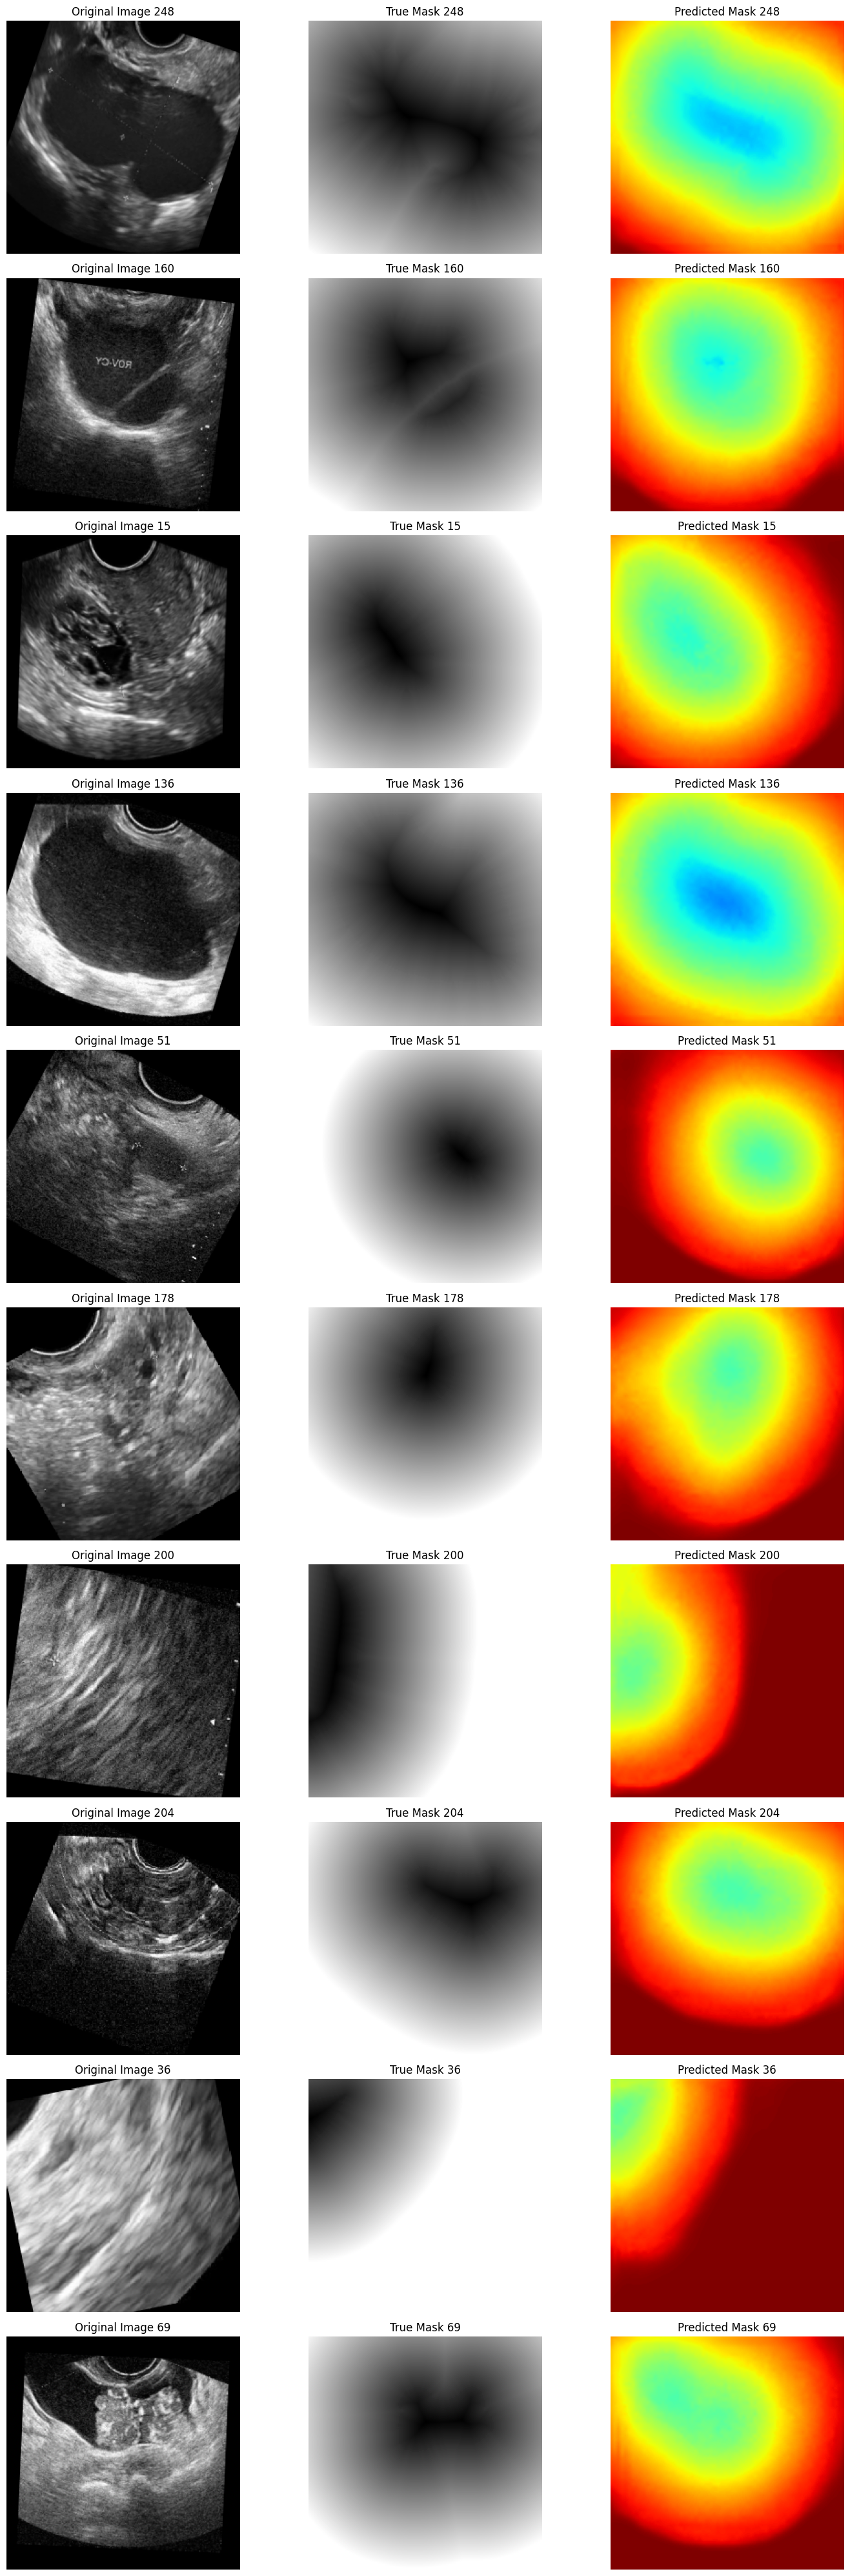

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation dataset
indices = torch.randperm(len(validation_dataset))[:10]

# Create a figure for plotting
fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 rows, 3 columns

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Get the ith sample
        image, true_mask = validation_dataset[idx]

        # Add batch dimension and transfer to the same device as model
        image_batch = image.unsqueeze(0).to(device)

        # Get model prediction
        prediction = model(image_batch)
        #predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu()
        predicted_mask = prediction.squeeze(0).cpu()

        # Convert tensors to numpy arrays for plotting
        image_np = image.squeeze().cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        predicted_mask_np = predicted_mask.numpy()

        # Plot original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image {idx}')

        # Plot true mask
        axs[i, 1].imshow(true_mask_np, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'True Mask {idx}')

        # Plot predicted mask
        axs[i, 2].imshow(predicted_mask_np[0], cmap='jet', vmax = 1, vmin = -1)
        axs[i, 2].axis('off')
        axs[i, 2].set_title(f'Predicted Mask {idx}')

plt.tight_layout()
plt.show()